In [6]:
import pandas as pd
import numpy as np
import os

#### Для начала стоит осмотреть данные с постами, которые мы хотим непосредственно рекомендовать и думать какие можно признаки вытащить

In [7]:
from dotenv import load_dotenv

load_dotenv()

SQLALCHEMY_DATABASE_URL = os.getenv('DATABASE_URL')

In [8]:
post_df = pd.read_sql("""

SELECT *
FROM post_text_df
""", con=SQLALCHEMY_DATABASE_URL)

post_df.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


Всего три таблицы, из которых только две подойдут для обучения (`post_id` мы разумеется брать не будем).   
`topic` можно обработать простым OneHotEncoding.  
`text` же представляет собою целое плато для размышлений и обработки, можно подключить нейронные сети и пытаться что-нибудь вынудить через эмбеддинги,как пример, но в данной работе мы ограничимся классическим машинным обучением.

In [3]:
import re
import string
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("wordnet")
wnl = nltk.stem.WordNetLemmatizer()

### Проведём предварительную обработку тескта (приведём все слова к нижнему регистру, проведём лемматизацию и т.д.)
def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line

### И применим Tf-Idf к нашим текстам
tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

tfidf

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TfidfVectorizer(preprocessor=<function preprocessing at 0x000002BD1DB555E0>,
                stop_words='english')

In [4]:
tfidf_data = (
    tfidf
    .fit_transform(post_df['text'])
    .toarray()
)

tfidf_data = pd.DataFrame(
    tfidf_data,
    index=post_df.post_id,
    columns=tfidf.get_feature_names_out()
)

### Сгенерируем признаки на основе Tf-Idf, хоть они и мало интрепретируемы для нас, но 
### могут привнести полезные данные для нашей модели

post_df['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
post_df['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
post_df['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

### Также, как идея, можно попытаться кластеризовать текста, предварительно ужав пространство нашего Tf-Idf в 
### меньшее n-мерное пространство

from sklearn.decomposition import PCA

### не забудем центрировать данные

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

post_df['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.436745,0.500714,0.437777,0.477197,0.428476,0.553747,0.440513,0.464118,0.440507,0.579304,0.508120,0.125018,0.449655,0.376001,0.527806
1,0.279863,0.374106,0.288027,0.340622,0.149924,0.450583,0.288724,0.327192,0.285377,0.342329,0.420347,0.266379,0.274404,0.198751,0.415385
2,0.320577,0.386724,0.311291,0.359297,0.326197,0.487340,0.310149,0.352243,0.316982,0.533915,0.434435,0.143298,0.325046,0.175177,0.431145
3,0.269124,0.353160,0.257480,0.321847,0.258925,0.451075,0.262570,0.294932,0.281536,0.494483,0.412342,0.252462,0.283584,0.082448,0.386846
4,0.228723,0.295410,0.159350,0.258644,0.209121,0.412975,0.178035,0.232956,0.214738,0.460993,0.356714,0.309681,0.195432,0.095941,0.346047


In [5]:
post_df = pd.concat((post_df,dists_df), axis=1)

post_df.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,11,0.436745,0.500714,0.437777,...,0.553747,0.440513,0.464118,0.440507,0.579304,0.508120,0.125018,0.449655,0.376001,0.527806
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,4,0.279863,0.374106,0.288027,...,0.450583,0.288724,0.327192,0.285377,0.342329,0.420347,0.266379,0.274404,0.198751,0.415385
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,11,0.320577,0.386724,0.311291,...,0.487340,0.310149,0.352243,0.316982,0.533915,0.434435,0.143298,0.325046,0.175177,0.431145
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,13,0.269124,0.353160,0.257480,...,0.451075,0.262570,0.294932,0.281536,0.494483,0.412342,0.252462,0.283584,0.082448,0.386846
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,13,0.228723,0.295410,0.159350,...,0.412975,0.178035,0.232956,0.214738,0.460993,0.356714,0.309681,0.195432,0.095941,0.346047


In [6]:
### Также как простеньний признак можно взять длину текстов

def get_len(x):
    return len(x)

post_df['len_of_text'] = post_df['text'].apply(lambda x: get_len(x))

In [7]:
### Сохраним признаки в отдельную таблицу, которую будем вызывать внутри рекомендательного сервиса

post_df.to_sql(
   "artyom_pavlov_posts_features",
    con=SQLALCHEMY_DATABASE_URL,
    if_exists='replace'
)

23

In [8]:
### Почистим переменные

del wnl
del tfidf
del pca
del PCA
del KMeans
del preprocessing

del tfidf_data
del centered
del pca_decomp
del kmeans
del dists_columns
del dists_df

import gc

gc.collect()

1131

К таблице feed_data я решил обратиться два раза, выбирая `target` положительным или отрицательным, чтобы не упираться в дальнейшем в дизбаланс классов.  
В топку признаков нашей модели из этих данных пойдут только время рекомендации (`hour`, `month`, `day_of_week`), а `timestamp` понадобится для деления всего нашего датасета на обучающую и тестирующую выборки, учитывая временную структуру наших данных.

In [9]:
feed_df_0 = pd.read_sql("""
    
    SELECT
    cast(extract(hour from timestamp) as int) as hour,
    CAST(EXTRACT (month from timestamp) as int) as month,
    cast(extract(dow from timestamp) as int) as day_of_week,
    timestamp,
    user_id,
    post_id,
    target
    
    FROM feed_data
    
    WHERE
    action = 'view' and target = 0
    
    Limit 2500000
    
    """, con=SQLALCHEMY_DATABASE_URL)
feed_df_0.head()

,hour,month,day_of_week,timestamp,user_id,post_id,target
0,19,11,4,2021-11-18 19:22:02,159816,7201,0
1,19,11,4,2021-11-18 19:26:13,159816,5316,0
2,19,11,4,2021-11-18 19:27:00,159816,6624,0
3,19,11,4,2021-11-18 19:28:21,159816,464,0
4,19,11,4,2021-11-18 19:29:46,159816,1369,0


In [10]:
feed_df_1 = pd.read_sql("""
    
    SELECT
    cast(extract(hour from timestamp) as int) as hour,
    CAST(EXTRACT (month from timestamp) as int) as month,
    CAST(EXTRACT (dow from timestamp) as int) as day_of_week,
    
    timestamp,
    user_id,
    post_id,
    target
    
    FROM feed_data
    
    WHERE
    action = 'view' and target = 1
    
    Limit 2500000
    
    """, con=SQLALCHEMY_DATABASE_URL)

feed_df_1.head()

,hour,month,day_of_week,timestamp,user_id,post_id,target
0,22,11,2,2021-11-23 22:04:18,31997,4669,1
1,22,11,2,2021-11-23 22:16:27,31997,954,1
2,22,11,2,2021-11-23 22:25:29,31997,2074,1
3,15,11,3,2021-11-24 15:05:55,31997,2785,1
4,15,11,3,2021-11-24 15:13:41,31997,266,1


In [11]:
feed_df = pd.concat((feed_df_0, feed_df_1), axis=0)

feed_df.head()

,hour,month,day_of_week,timestamp,user_id,post_id,target
0,19,11,4,2021-11-18 19:22:02,159816,7201,0
1,19,11,4,2021-11-18 19:26:13,159816,5316,0
2,19,11,4,2021-11-18 19:27:00,159816,6624,0
3,19,11,4,2021-11-18 19:28:21,159816,464,0
4,19,11,4,2021-11-18 19:29:46,159816,1369,0


In [12]:
user_df = pd.read_sql("""
    SELECT *
    FROM user_data
    """, con=SQLALCHEMY_DATABASE_URL)
user_df.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


Здесь все признаки подходят для нашей модели (кроме, разумеется, `user_id`).  
Колонку с возрастом можно разным образом обрабатывать, но я решил попробовать через отнесение деление на отдельные категории

In [13]:
def get_age_category(x):
    
    if x <= 17:
        return 'Kid'
    elif x >= 18 and x <= 30:
        return 'Young'
    elif x >= 31 and x <= 60:
        return 'Adult'
    else: 
        return 'Old'
    
user_df['age_category'] = user_df['age'].apply(lambda x: get_age_category(x))

In [14]:
user_df = user_df.drop('age', axis=1)

In [15]:
### Также сохраняем наши признаки для юзеров

user_df.to_sql(
   "artyom_pavlov_users_features",
    con=SQLALCHEMY_DATABASE_URL,
    if_exists='replace'
)

205

In [16]:
### Объединим все таблицы в одну

df = pd.merge(user_df,
             feed_df,
             how='right',
             on='user_id')

df = pd.merge(post_df.drop('text',axis=1),
             df,
             how='right',
             on='post_id')

df.head()

,post_id,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,...,city,exp_group,os,source,age_category,hour,month,day_of_week,timestamp,target
0,7201,movie,8.203046,0.272678,0.000178,3,0.326486,0.149341,0.251671,0.117490,...,Kursk,4,Android,organic,Adult,19,11,4,2021-11-18 19:22:02,0
1,5316,movie,7.749370,0.536321,0.000168,6,0.278607,0.265894,0.196476,0.224424,...,Kursk,4,Android,organic,Adult,19,11,4,2021-11-18 19:26:13,0
2,6624,movie,8.430242,0.207907,0.000183,6,0.265102,0.240626,0.158000,0.203221,...,Kursk,4,Android,organic,Adult,19,11,4,2021-11-18 19:27:00,0
3,464,business,9.290125,0.469863,0.000202,13,0.314524,0.377993,0.282193,0.348371,...,Kursk,4,Android,organic,Adult,19,11,4,2021-11-18 19:28:21,0
4,1369,politics,8.234696,0.475689,0.000179,4,0.317928,0.366190,0.286923,0.337257,...,Kursk,4,Android,organic,Adult,19,11,4,2021-11-18 19:29:46,0


In [17]:
### И установим user_id и post_id индексами этой таблицы

df = df.set_index(['user_id', 'post_id'])
df.head()

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                           
159816  7201        movie    8.203046  0.272678   0.000178            3   
        5316        movie    7.749370  0.536321   0.000168            6   
        6624        movie    8.430242  0.207907   0.000183            6   
        464      business    9.290125  0.469863   0.000202           13   
        1369     politics    8.234696  0.475689   0.000179            4   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
159816  7201                 0.326486              0.149341   
        5316                 0.278607              0.265894   
        6624                 0.265102              0.240626   
        464                  0.314524              0.377993   
        1369                 0.317928              0.366190   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
159816  7201                 0.251671              0.117490   
        5316                 0.196476              0.224424   
        6624                 0.158000              0.203221   
        464                  0.282193              0.348371   
        1369                 0.286923              0.337257   

                 DistanceTo5thCluster  ...   city  exp_group       os  \
user_id post_id                        ...                              
159816  7201                 0.319951  ...  Kursk          4  Android   
        5316                 0.208485  ...  Kursk          4  Android   
        6624                 0.250179  ...  Kursk          4  Android   
        464                  0.264062  ...  Kursk          4  Android   
        1369                 0.140296  ...  Kursk          4  Android   

                  source  age_category  hour  month  day_of_week  \
user_id post_id                                                    
159816  7201     organic         Adult    19     11            4   
        5316     organic         Adult    19     11            4   
        6624     organic         Adult    19     11            4   
        464      organic         Adult    19     11            4   
        1369     organic         Adult    19     11            4   

                          timestamp  target  
user_id post_id                              
159816  7201    2021-11-18 19:22:02       0  
        5316    2021-11-18 19:26:13       0  
        6624    2021-11-18 19:27:00       0  
        464     2021-11-18 19:28:21       0  
        1369    2021-11-18 19:29:46       0  

[5 rows x 33 columns]

Посмотрим на время первых и последних записей и по ним будем смотреть, как лучше разделить наши данные.

In [18]:
max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:03:20'))

In [19]:
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((4118293,), (881707,))

In [20]:
X_train.columns

Index(['topic', 'TotalTfIdf', 'MaxTfIdf', 'MeanTfIdf', 'TextCluster',
       'DistanceTo1thCluster', 'DistanceTo2thCluster', 'DistanceTo3thCluster',
       'DistanceTo4thCluster', 'DistanceTo5thCluster', 'DistanceTo6thCluster',
       'DistanceTo7thCluster', 'DistanceTo8thCluster', 'DistanceTo9thCluster',
       'DistanceTo10thCluster', 'DistanceTo11thCluster',
       'DistanceTo12thCluster', 'DistanceTo13thCluster',
       'DistanceTo14thCluster', 'DistanceTo15thCluster', 'len_of_text',
       'gender', 'country', 'city', 'exp_group', 'os', 'source',
       'age_category', 'hour', 'month', 'day_of_week'],
      dtype='object')

In [21]:
### Синхронизируем порядок колонок

cols_ = [
       'topic', 'TotalTfIdf', 'MaxTfIdf', 'MeanTfIdf', 'TextCluster',
       'DistanceTo1thCluster', 'DistanceTo2thCluster', 'DistanceTo3thCluster',
       'DistanceTo4thCluster', 'DistanceTo5thCluster', 'DistanceTo6thCluster',
 'DistanceTo7thCluster',
 'DistanceTo8thCluster',
 'DistanceTo9thCluster',
 'DistanceTo10thCluster',
 'DistanceTo11thCluster',
 'DistanceTo12thCluster',
 'DistanceTo13thCluster',
 'DistanceTo14thCluster',
 'DistanceTo15thCluster', 'len_of_text', 'gender', 'country', 'city',
       'exp_group', 'os', 'source', 'age_category', 'hour', 'month', 'day_of_week'
]

X_train = X_train[cols_]
X_test = X_test[cols_]

del cols_

In [22]:
### Ещё раз внимательно осмотрим наши признаки

df_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4118293 entries, (159816, 7201) to (99523, 2270)
Data columns (total 32 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   topic                  object 
 1   TotalTfIdf             float64
 2   MaxTfIdf               float64
 3   MeanTfIdf              float64
 4   TextCluster            int32  
 5   DistanceTo1thCluster   float64
 6   DistanceTo2thCluster   float64
 7   DistanceTo3thCluster   float64
 8   DistanceTo4thCluster   float64
 9   DistanceTo5thCluster   float64
 10  DistanceTo6thCluster   float64
 11  DistanceTo7thCluster   float64
 12  DistanceTo8thCluster   float64
 13  DistanceTo9thCluster   float64
 14  DistanceTo10thCluster  float64
 15  DistanceTo11thCluster  float64
 16  DistanceTo12thCluster  float64
 17  DistanceTo13thCluster  float64
 18  DistanceTo14thCluster  float64
 19  DistanceTo15thCluster  float64
 20  len_of_text            int64  
 21  gender                 int64  
 22 

In [23]:
object_cols = [
        'topic',  'TextCluster', 'gender', 'country', 'city',
       'exp_group', 'os', 'source', 'age_category', 'hour', 'month', 'day_of_week'
]

from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, object_cols)

0:	learn: 0.6276539	total: 2.74s	remaining: 4m 31s
1:	learn: 0.5986794	total: 4.94s	remaining: 4m 2s
2:	learn: 0.5898031	total: 6.38s	remaining: 3m 26s
3:	learn: 0.5850109	total: 7.76s	remaining: 3m 6s
4:	learn: 0.5815412	total: 9.05s	remaining: 2m 51s
5:	learn: 0.5793823	total: 10.8s	remaining: 2m 49s
6:	learn: 0.5787350	total: 12.2s	remaining: 2m 41s
7:	learn: 0.5779826	total: 13.5s	remaining: 2m 34s
8:	learn: 0.5776827	total: 14.8s	remaining: 2m 29s
9:	learn: 0.5770293	total: 16.1s	remaining: 2m 24s
10:	learn: 0.5764818	total: 17.3s	remaining: 2m 20s
11:	learn: 0.5762341	total: 18.6s	remaining: 2m 16s
12:	learn: 0.5760127	total: 20s	remaining: 2m 13s
13:	learn: 0.5756365	total: 21.3s	remaining: 2m 10s
14:	learn: 0.5731866	total: 22.6s	remaining: 2m 8s
15:	learn: 0.5728056	total: 23.8s	remaining: 2m 5s
16:	learn: 0.5723027	total: 25.4s	remaining: 2m 3s
17:	learn: 0.5719230	total: 26.6s	remaining: 2m 1s
18:	learn: 0.5718473	total: 27.8s	remaining: 1m 58s
19:	learn: 0.5717531	total: 29

In [27]:
from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.7699553138508719
Качество на тесте: 0.7521428591167194


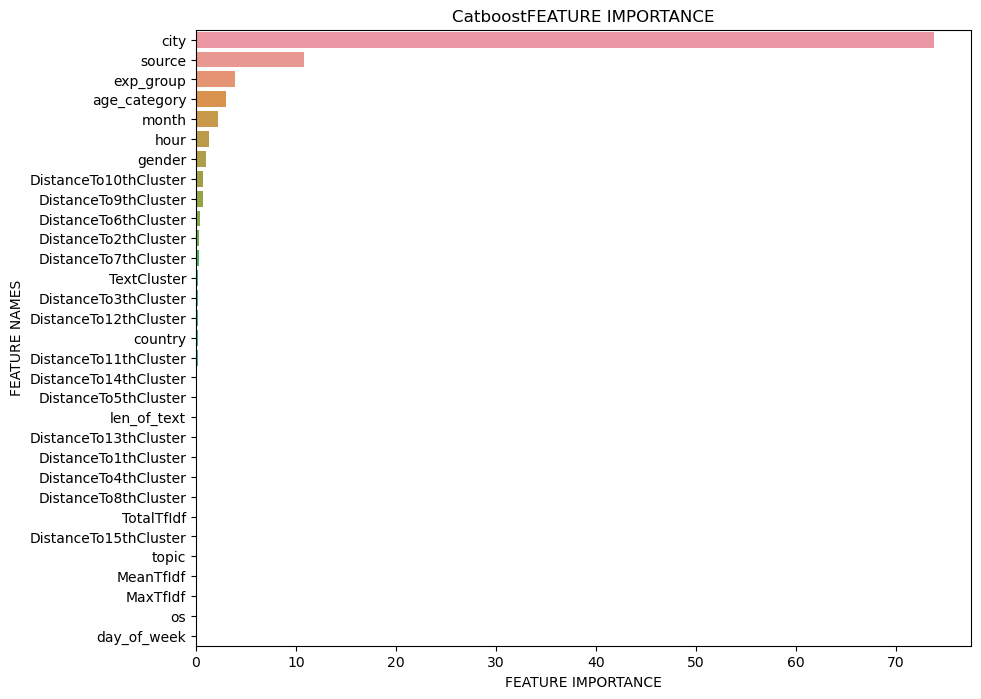

In [25]:
### Поистроим график значимости наших признаков для чистого любопытства

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [28]:
catboost.save_model(
    'catboost_git',
    format="cbm"
)